Data for this notebook was retreived from the UC-Irvine ML repository: http://archive.ics.uci.edu/ml/datasets/Car+Evaluation

Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from datetime import datetime
plt.style.use('fivethirtyeight')

## Read in the data

In [2]:
data = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data',
                  names=['buying', 'maint', 'doors', 'persons',
                         'lug_boot', 'safety', 'target'])

In [3]:
data.head()

,buying,maint,doors,persons,lug_boot,safety,target
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [4]:
for var in data.columns:
    print('\n' + var)
    print(np.unique(data[var]))


buying
['high' 'low' 'med' 'vhigh']

maint
['high' 'low' 'med' 'vhigh']

doors
['2' '3' '4' '5more']

persons
['2' '4' 'more']

lug_boot
['big' 'med' 'small']

safety
['high' 'low' 'med']

target
['acc' 'good' 'unacc' 'vgood']


In [5]:
### what's the distribution of the target variable?
data.target.value_counts()

### because there are so few in the good/vgood and this is really just a
### theoretical exercise, we'll lump them together

unacc    1210
acc       384
good       69
vgood      65
Name: target, dtype: int64

In [6]:
### many of these columns need to be converted to numerical scores
scores = data.copy(deep=True)

scores.buying = scores.buying.map({'low': 1,
                                                   'med': 2,
                                                   'high': 3,
                                                   'vhigh': 4})

scores.maint = scores.maint.map({'low': 1,
                                                   'med': 2,
                                                   'high': 3,
                                                   'vhigh': 4})

scores.doors = scores.doors.replace('5.+', '5', regex=True).astype(int)

### For 'more', we're just going to say 6
scores.persons = scores.persons.replace('more', '6').astype(int)

scores.lug_boot = scores.lug_boot.map({'small': 1,
                                      'med': 2,
                                      'big': 3})

scores.safety = scores.safety.map({'low': 1,
                                      'med': 2,
                                      'high': 3})

scores.target = scores.target.map({'unacc': 0,
                                  'acc': 1,
                                  'good': 2,
                                  'vgood': 2})

In [7]:
### did that work? Great
print(scores.info())
scores.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   buying    1728 non-null   int64
 1   maint     1728 non-null   int64
 2   doors     1728 non-null   int64
 3   persons   1728 non-null   int64
 4   lug_boot  1728 non-null   int64
 5   safety    1728 non-null   int64
 6   target    1728 non-null   int64
dtypes: int64(7)
memory usage: 94.6 KB
None


,buying,maint,doors,persons,lug_boot,safety,target
0,4,4,2,2,1,1,0
1,4,4,2,2,1,2,0
2,4,4,2,2,1,3,0
3,4,4,2,2,2,1,0
4,4,4,2,2,2,2,0


## Split data into training and test sets

In [8]:
X = scores.iloc[:,:6].to_numpy()
y = np.array(scores.target)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                    test_size=0.3, random_state=42)

### Build the pipeline and find the best hyperparameters

In [9]:
knn_reg = KNeighborsClassifier()
parameters = {'knn__n_neighbors': list(range(1,10)),
             'knn__p': list(range(4)),
             'knn__weights': ['uniform', 'distance']}

pipe = Pipeline([('scaler', MinMaxScaler()),
                ('knn', knn_reg)])

knn_reg_gs = GridSearchCV(pipe, param_grid = parameters,
                         cv = 5, n_jobs=-1)

knn_reg_gs.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        MinMaxScaler(copy=True,
                                                     feature_range=(0, 1))),
                                       ('knn',
                                        KNeighborsClassifier(algorithm='auto',
                                                             leaf_size=30,
                                                             metric='minkowski',
                                                             metric_params=None,
                                                             n_jobs=None,
                                                             n_neighbors=5, p=2,
                                                             weights='uniform'))],
                                verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'knn__n_neig

In [10]:
knn_reg_gs.best_estimator_

Pipeline(memory=None,
         steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('knn',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=None, n_neighbors=6, p=1,
                                      weights='distance'))],
         verbose=False)

In [11]:
means = knn_reg_gs.cv_results_['mean_test_score']

In [12]:
### predict on test data
test_preds = knn_reg_gs.best_estimator_.predict(X_test)

In [13]:
### What's the accuracy score? Not bad.
print(f'Pct correct predictions: {np.round(accuracy_score(y_test, test_preds),3)}\n')

print(classification_report(y_test, test_preds))

Pct correct predictions: 0.963

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       358
           1       0.95      0.89      0.92       118
           2       0.86      0.86      0.86        43

    accuracy                           0.96       519
   macro avg       0.93      0.92      0.92       519
weighted avg       0.96      0.96      0.96       519



### Visualize performance of different hyperparams

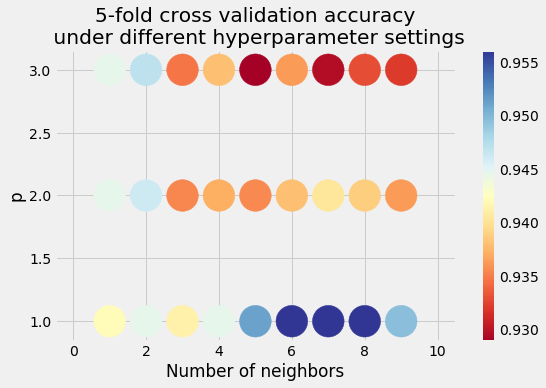

In [14]:
### Look at acuracy for different values of p and k for weighted results
weight_idx = knn_reg_gs.cv_results_['param_knn__weights'].data=='distance'

plt.figure(figsize=(8,5))
plt.scatter(knn_reg_gs.cv_results_['param_knn__n_neighbors'].data[weight_idx],
            knn_reg_gs.cv_results_['param_knn__p'].data[weight_idx],
                     c=means[weight_idx], cmap='RdYlBu', s=1000)
plt.colorbar()
plt.xlabel("Number of neighbors")
plt.ylabel("p")
plt.xlim(-0.5, 10.5)
plt.title("5-fold cross validation accuracy\n under different hyperparameter settings")
plt.show()

In [15]:
### Now let's look at scores for different neighbors under the 
### best performing p and weighted distance
p1_idxs = knn_reg_gs.cv_results_['param_knn__p'].data==1
### combine with weight idx
idxs = []
for i,j in zip(p1_idxs, weight_idx):
    if i and j: idxs.append(True)
    else: idxs.append(False)
idxs = np.array(idxs)

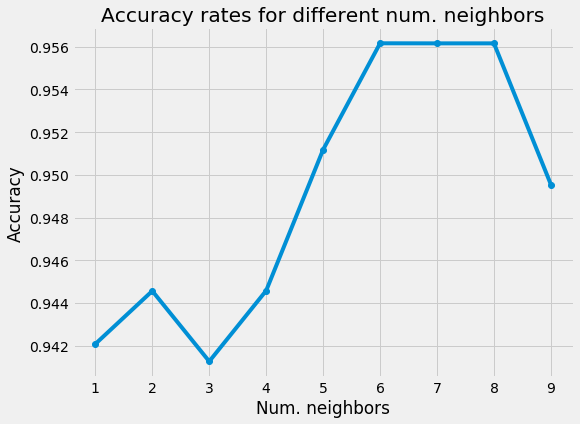

In [16]:
### event though the best performing number of neighbors was
### technically 6, we can see there's really no difference from 7 or 8
plt.figure(figsize=(8,6))
plt.plot(knn_reg_gs.cv_results_['param_knn__n_neighbors'].data[idxs],
        means[idxs], 'o-')
plt.xlabel('Num. neighbors')
plt.ylabel('Accuracy')
plt.title('Accuracy rates for different num. neighbors')
plt.show()